In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

# Import TensorFlow Datasets
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

# Helper libraries
import math
import numpy as np
import matplotlib.pyplot as plt

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [0]:
dataset, metadata = tfds.load('beans',as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

In [4]:
num_train_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples

print("Number of training examples: {}".format(num_train_examples))
print("Number of test examples:     {}".format(num_test_examples))

class_names = ["Disease Type 1","Disease Type 2","Healthy"]

Number of training examples: 1034
Number of test examples:     128


In [5]:
for (image,labels) in train_dataset.take(1):
  print(len(image),len(image[0]),len(image[0][0]))

train_dataset = train_dataset.cache()
test_dataset = test_dataset.cache()

500 500 3


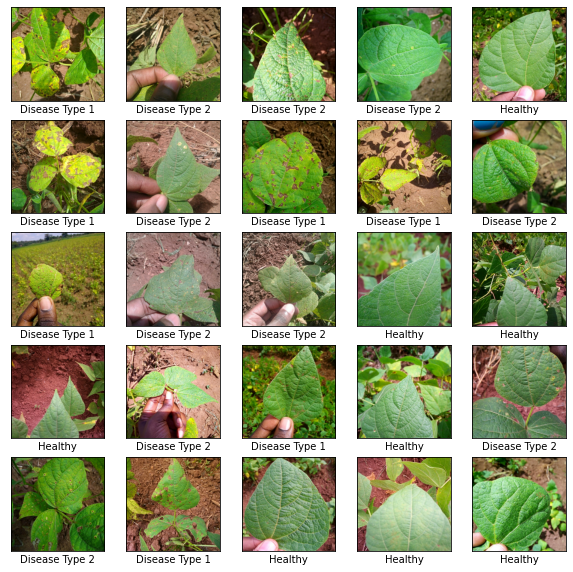

In [6]:
plt.figure(figsize=(10,10))
i = 0

for (image,label) in test_dataset.take(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.xlabel(class_names[label])
  plt.imshow(image)
  i += 1
plt.show()

In [0]:
model = tf.keras.Sequential([
tf.keras.layers.Conv2D(64, (2,2),padding='same', activation=tf.nn.relu,input_shape=(500,500,3),data_format='channels_last'),
tf.keras.layers.MaxPooling2D((2,2), strides=2),
tf.keras.layers.Conv2D(32, (2,2),padding='same',activation=tf.nn.relu),
tf.keras.layers.MaxPooling2D((2,2), strides=2),
tf.keras.layers.Conv2D(32, (2,2),padding='same',activation=tf.nn.relu),
tf.keras.layers.MaxPooling2D((2,2), strides=2),
tf.keras.layers.Conv2D(32, (2,2),padding='same',activation=tf.nn.relu),
tf.keras.layers.MaxPooling2D((2,2), strides=2),
tf.keras.layers.Conv2D(32, (2,2),padding='same',activation=tf.nn.relu),
tf.keras.layers.MaxPooling2D((2,2), strides=2),
tf.keras.layers.Conv2D(32, (2,2),padding='same',activation=tf.nn.relu),
tf.keras.layers.MaxPooling2D((2,2), strides=2),
tf.keras.layers.Conv2D(32, (2,2),padding='same',activation=tf.nn.relu),
tf.keras.layers.MaxPooling2D((2,2), strides=2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128,activation=tf.nn.relu),
tf.keras.layers.Dense(3,activation=tf.nn.softmax)                             
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [8]:
BATCH_SIZE = 32
train_dataset = train_dataset.repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset.batch(BATCH_SIZE)

model.fit(train_dataset,epochs=5,steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/5
33/33 [==============================] - 13s 400ms/step - loss: 1.4683 - accuracy: 0.4062
Epoch 2/5
33/33 [==============================] - 13s 400ms/step - loss: 0.8943 - accuracy: 0.5824
Epoch 3/5
33/33 [==============================] - 13s 400ms/step - loss: 0.7978 - accuracy: 0.6411
Epoch 4/5
33/33 [==============================] - 13s 402ms/step - loss: 0.6782 - accuracy: 0.6866
Epoch 5/5
33/33 [==============================] - 13s 401ms/step - loss: 0.5775 - accuracy: 0.7604


In [0]:
def normalize_reshape(images,labels):
  images = tf.reshape(images,(1,500,500,3))
  return images,labels

In [10]:
test_dataset = test_dataset.map(normalize_reshape) 
test_loss, test_accuracy = model.evaluate(test_dataset)
print('Accuracy on test dataset:', test_accuracy)

128/128 [==============================] - 1s 7ms/step - loss: 0.5681 - accuracy: 0.8047
Accuracy on test dataset: 0.8046875


In [0]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])

predictions = probability_model.predict(test_dataset)

In [0]:
def plot_image(i, predictions_array, true_label, img):
  #predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  #predictions_array, true_label = predictions_array, true_label
  plt.grid(False)
  plt.xticks(range(3))
  plt.yticks([])
  thisplot = plt.bar(range(3), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [13]:
predictions[1]

array([0.33477044, 0.43095168, 0.2342779 ], dtype=float32)

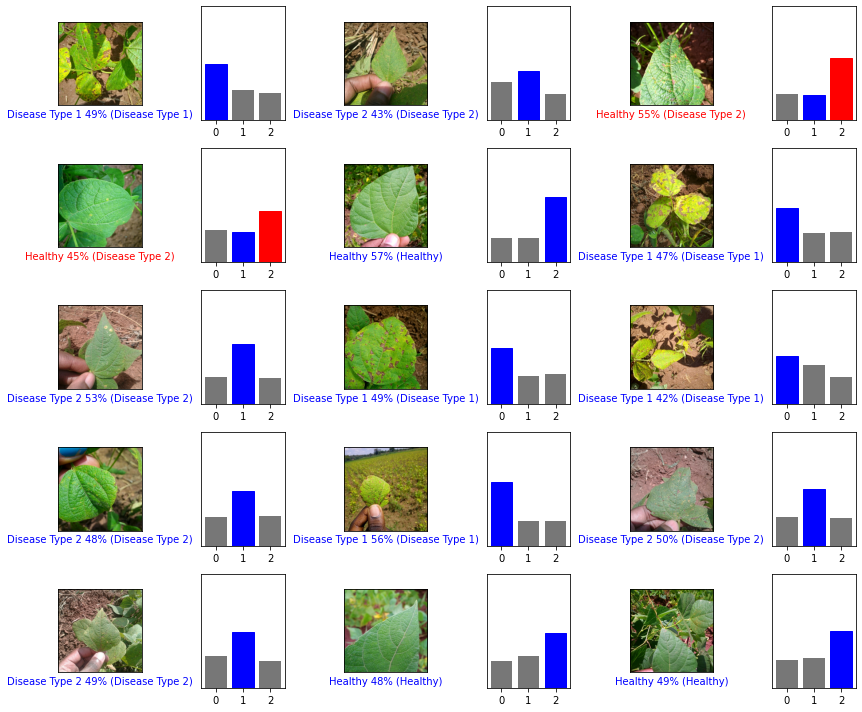

In [14]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
counter = 0
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for test_images,test_labels in test_dataset:
  test_images = tf.reshape(test_images,(500,500,3))
  plt.subplot(num_rows, 2*num_cols, 2*counter+1)
  plot_image(counter, predictions[counter], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*counter+2)
  plot_value_array(counter, predictions[counter], test_labels)
  if counter >= 14:
    break
  counter = counter + 1

plt.tight_layout()
plt.show()